### In this project we will try to predict whether a given Reddit comment is sarcastic or not

Dataset can be downloaded from this link: https://www.kaggle.com/danofer/sarcasm

**Let's import some useful libraries**

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

**Here we download our data and look at the list of columns in the dataframe**

In [5]:
train_df = pd.read_csv('Desktop/train-balanced-sarcasm.csv')

In [9]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


**Let's drop rows with missing comments from our dataset**

In [11]:
train_df.dropna(subset=['comment'], inplace=True)

**Here we can see that our classes (sarcastic and non-sarcastic comments) are well-balanced**

In [14]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

**Now we will split data into 2 parts: train and validation**

In [17]:
train_texts, valid_texts, y_train, y_valid = \
    train_test_split(train_df['comment'], train_df['label'], random_state=44)

**Let's perform some exploratory data analysis**

**We can see that lengths of sarcastic and non-sarcastic comments are distributed approximately the same**

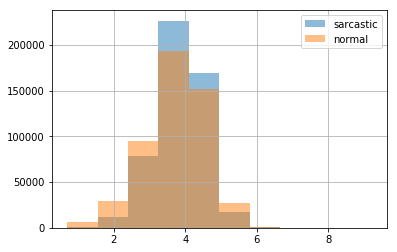

In [20]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend()

In [23]:
from wordcloud import WordCloud, STOPWORDS

In [24]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 44, width=800, height=400)

**There's a short illustration of the most common words for sarcastic and non-sarcastic comments respectively**

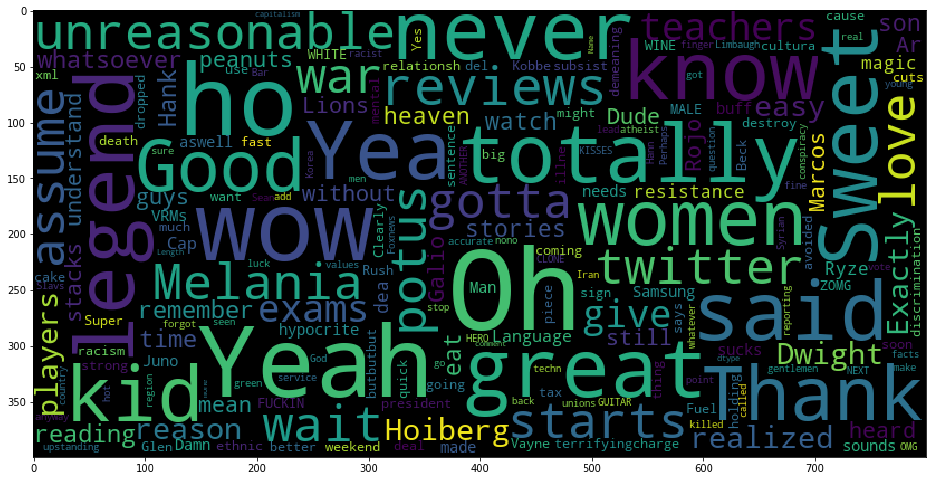

In [25]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

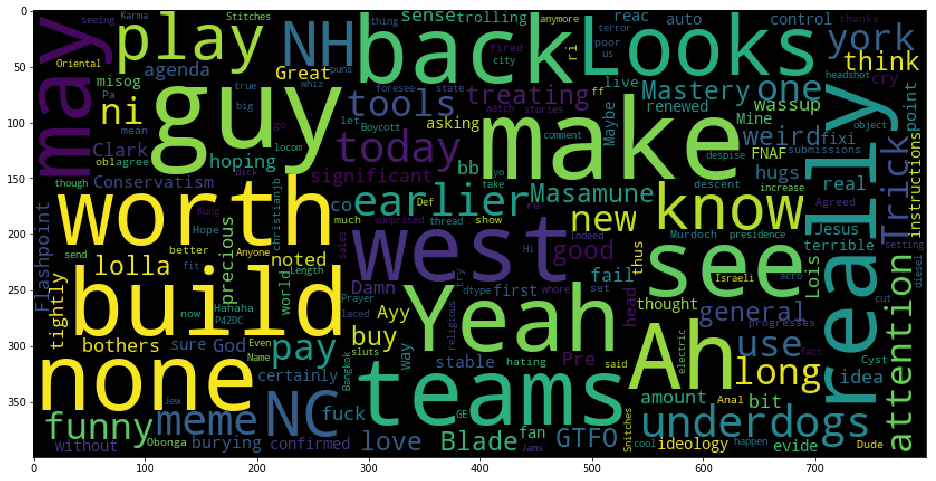

In [26]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud)

In [52]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])

**The following 4 tables show that we won't be able to detect sarcasm with descent quality based on topic, author or comment score**

In [53]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [29]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [30]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [31]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


**Now let's build a ML model to detect sarcasm**

In [32]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=44, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

**Let's train the model**

In [33]:
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.4s finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru... penalty='l2', random_state=44, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False))])

In [34]:
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

**We achieved 72% accuracy on validation set**

In [35]:
accuracy_score(y_valid, valid_pred)

0.7205592534844516

**Confusion matrix is quite balanced which means that frequencies of type 1 and type 2 mistakes do not differ severely**

In [36]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

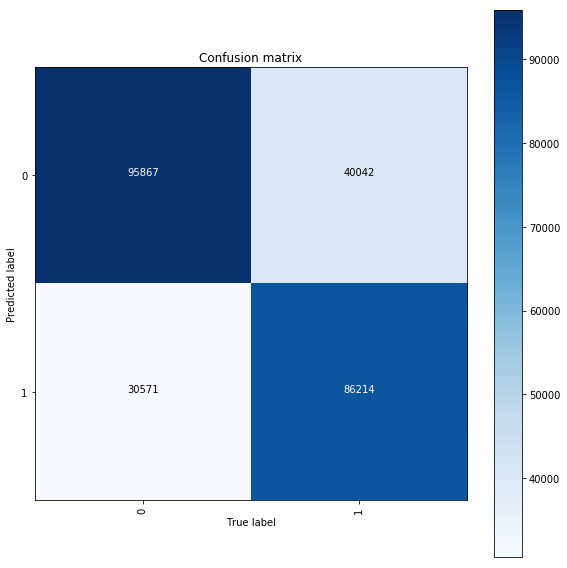

In [37]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

**In the end we can visualize what terms are the strongest predictors of sarcastic and non-sarcastic comments**

In [39]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Using TensorFlow backend.


Weight?,Feature
+10.111,yes because
+8.575,obviously
+7.773,clearly
+7.496,yeah because
+7.297,totally
+5.902,gee
+5.832,how dare
+5.812,because
+5.676,right because
+5.625,but thought


**So was our score good enough? Yes, because it's obviously totally clearly a very primitive problem)))** 